### Comparison of two models, paired test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import uniform, norm
import json

In [2]:
def extract_bounds(intervals):
        if isinstance(intervals, pd.Interval):
            return [intervals.left], [intervals.right]
        elif all(isinstance(interval, pd.Interval) for interval in intervals):
            lower_bounds = [interval.left for interval in intervals]
            upper_bounds = [interval.right for interval in intervals]
            return lower_bounds, upper_bounds
        else:
            raise TypeError("All elements must be pandas Interval objects or a single Interval object")

Select your two files containing the errors, with the same metric, of two models or two samples

In [3]:
errors_file_A = pd.read_csv("Errors/Errors_linear_model_MSE_.csv")
errors_A = errors_file_A.values.flatten()
errors_file_B = pd.read_csv("Errors/Errors_quadratic_model_MSE_.csv")
errors_B = errors_file_B.values.flatten()
errors = errors_A - errors_B
errors


array([-2.19727036e-01,  8.96968382e-01, -3.06352256e-01,  3.66007562e-01,
        2.97778840e-01, -8.11318287e-02, -6.39680236e-01, -2.54684044e-01,
        4.66122456e-01, -1.52003724e-01, -2.06270949e-02,  3.32200500e-03,
       -1.86719419e-01, -1.22293978e-01,  2.75482765e-01,  9.93806846e-01,
        1.67598790e-01,  8.82059077e-02,  3.00950663e-01,  1.10242974e-01,
       -7.72139425e-02, -8.40147157e-01, -9.44641515e-01, -2.27637506e-01,
        4.19412352e-01,  1.92615642e-01,  1.89217059e-01,  5.08507291e-01,
        3.64914237e-01,  1.48014789e-01, -2.32022145e-02, -6.76936744e-01,
       -6.41302075e-02,  7.21147025e-01,  4.65758118e-02, -1.56866154e-01,
       -4.38216140e-02,  1.25244009e+00, -7.15679529e-01, -3.70079350e-01,
       -7.15077155e-01, -2.87950037e-01,  3.81775159e-02, -2.12899303e-04,
        1.73616556e-01,  4.80638390e-01, -2.61089795e-03, -2.45293363e-01,
       -1.73479389e-01,  3.17264857e-01, -4.46298262e-01,  3.72860397e-01,
        6.31060730e-01,  

In [4]:
def descriptive_statistics():

    alpha = 0.05

    empirical_mean = np.mean(errors)
    empirical_std_deviation = np.std(errors, ddof=1)
    q1 = np.percentile(errors, 25)
    med = np.percentile(errors, 50)
    q3 = np.percentile(errors, 75)

    print("The empirical mean is :", empirical_mean)
    print("The empirical standard deviation is :", empirical_std_deviation)
    print("The empirical first quartile is :", q1)
    print("The empirical mediane is :", med)
    print("The empirical third quartile is :", q3)

    std_error_param = empirical_std_deviation/(len(errors)**0.5)

    B = 250
    bootstrap_indices = np.random.choice(len(errors), size=(B, len(errors)), replace=True)
    bootstrap = []

    for indices in bootstrap_indices:
      boot_mean = np.mean(errors[indices])
      bootstrap.append(boot_mean)

    bootstrapped_mean = np.mean(bootstrap)
    bootstrapped_std_error = np.std(bootstrap)

    print("The bootstrapped empirical mean is :", bootstrapped_mean)
    print("The empirical standard error is :", std_error_param)
    print("The bootstrapped empirical standard error is :", bootstrapped_std_error)

    t_critical = 1.96
    lower = empirical_mean - t_critical * std_error_param
    upper = empirical_mean + t_critical * std_error_param

    conf_interval = pd.Interval(left=lower, right=upper, closed='both')

    print("A 95'%' confidence interval for the mean is :", conf_interval)

    lower_boot = np.percentile(bootstrap , 100 * (alpha/2))
    upper_boot = np.percentile(bootstrap, 100 * (1 - alpha / 2))

    conf_interval_perc_boot = pd.Interval(left=lower_boot, right=upper_boot, closed='both')

    print("A 95'%' percentile boostrap confidence interval for the mean is :", conf_interval_perc_boot)

    conf_interval_basic_boot = pd.Interval(left=2*empirical_mean-upper_boot, right=2*empirical_mean-lower_boot, closed='both')

    print("A 95'%' basic boostrap confidence interval for the mean is :", conf_interval_basic_boot)

    # Acceleration
    jackknife_samples = np.array([np.mean(np.delete(errors, i)) for i in range(len(errors))])
    jackknife_mean = np.mean(jackknife_samples)
    a = np.sum((jackknife_mean - jackknife_samples) ** 3) / (6 * np.sum((jackknife_mean - jackknife_samples) ** 2) ** 1.5)

    # Bias correction
    z0 = stats.norm.ppf(np.mean(bootstrap < empirical_mean))

    z_alpha = norm.ppf(alpha / 2)
    z_1_alpha = norm.ppf(1 - alpha / 2)
    
    lower_percentile = norm.cdf(z0 + (z0 + z_alpha) / (1 - a * (z0 + z_alpha))) * 100
    upper_percentile = norm.cdf(z0 + (z0 + z_1_alpha) / (1 - a * (z0 + z_1_alpha))) * 100

    conf_interval_bca_boot = np.percentile(bootstrap, [lower_percentile, upper_percentile])

    print("A 95'%' accelerated boostrap confidence interval for the mean is :", conf_interval_bca_boot)

    y1, y2 = extract_bounds(conf_interval)
    y3, y4 = extract_bounds(conf_interval_basic_boot)
    y5, y6 = extract_bounds(conf_interval_perc_boot)
    y7, y8 = conf_interval_bca_boot[0], conf_interval_bca_boot[1]

    plt.figure(figsize=(10, 6))
    plt.axhline(y1, label='lower bound student mean interval ', marker='o', color="lightblue")
    plt.axhline(y2, label='upper bound student mean interval', marker='o', color="darkblue")
    plt.axhline(y3, label='lower bound Basic boot', marker='o', color="brown")
    plt.axhline(y4, label='upper bound Basic boot', marker='o', color="darkred")
    plt.axhline(y5, label='lower bound Perc boot', marker='o', color="lightgreen")
    plt.axhline(y6, label='upper bound Perc boot', marker='o', color="darkgreen")
    plt.axhline(y7, label='lower bound BCA boot', marker='o', color="yellow")
    plt.axhline(y8, label='upper bound BCA boot', marker='o', color="orange")

    plt.xlabel('')
    plt.title('Different confidence intervals of mean of the difference')
    plt.legend()
    plt.grid(True)
    plt.show()

    supposed_mean = 0 # to change (here, equality of performance)

    test_stat = empirical_mean-supposed_mean/std_error_param # Bilateral test : Model A has the same performance as model B.
    student = stats.t.ppf(1-alpha/2, df=len(errors)-1)
    p_value = 1 - stats.t.cdf(test_stat, df=len(errors)-1)
    puissance = 1 - stats.norm.cdf(student - test_stat, 0, 1)

    print("The following bilateral test checks if your hypothesis on the equal performance of two models is reasonable :")
    print("The p-value of the bilateral test is :", p_value)
    print("The power of the bilateral test is :", puissance)

    # With bootstrapped values

    test_stat_boot = bootstrapped_mean-supposed_mean/bootstrapped_std_error 
    p_value_boot = 1 - stats.t.cdf(test_stat_boot, df=len(errors)-1)
    puissance_boot = 1 - stats.norm.cdf(student - test_stat, 0, 1)

    print("The bootstrapped p-value of the bilateral test is :", p_value_boot)
    print("The bootstrapped power of the bilateral test is :", puissance_boot)


    data = {
    "Empirical mean": empirical_mean,
    "Empirical standard deviation": empirical_std_deviation,
    "Empirical first quartile": q1,
    "Empirical median": med,
    "Empirical third quartile": q3,
    "Bootstrapped empirical mean": bootstrapped_mean,
    "Empirical standard error": bootstrapped_std_error,
    "Bootstrapped empirical standard error": std_error_param,
    "95% confidence interval for the mean": str(conf_interval),
    "95% percentile bootstrap confidence interval for the mean": str(conf_interval_perc_boot),
    "95% basic bootstrap confidence interval for the mean": str(conf_interval_basic_boot),
    "95% accelerated bootstrap confidence interval for the mean": str(conf_interval_bca_boot)
}

    additionnal_info = "Logistic_vs_DecisionTree_gamma90"
    json_file_path = f"Summary/statistics_comparison_{additionnal_info}_summary.json" # a modifier
    with open(json_file_path, 'w') as json_file:
       json.dump(data, json_file, indent=4)

    print(f"Les données ont été sauvegardées dans le fichier {json_file_path}")


The empirical mean is : 0.12638710631190014
The empirical standard deviation is : 0.4940409170146821
The empirical first quartile is : -0.11917184830290926
The empirical mediane is : 0.04213793114116163
The empirical third quartile is : 0.3641060936528532
The bootstrapped empirical mean is : 0.12692662129152088
The empirical standard error is : 0.028523465642911625
The bootstrapped empirical standard error is : 0.028873738299852687
A 95'%' confidence interval for the mean is : [0.07048111365179335, 0.18229309897200693]
A 95'%' percentile boostrap confidence interval for the mean is : [0.07395884070290377, 0.1810143454976746]
A 95'%' basic boostrap confidence interval for the mean is : [0.0717598671261257, 0.17881537192089653]
A 95'%' accelerated boostrap confidence interval for the mean is : [0.07285066 0.18051139]


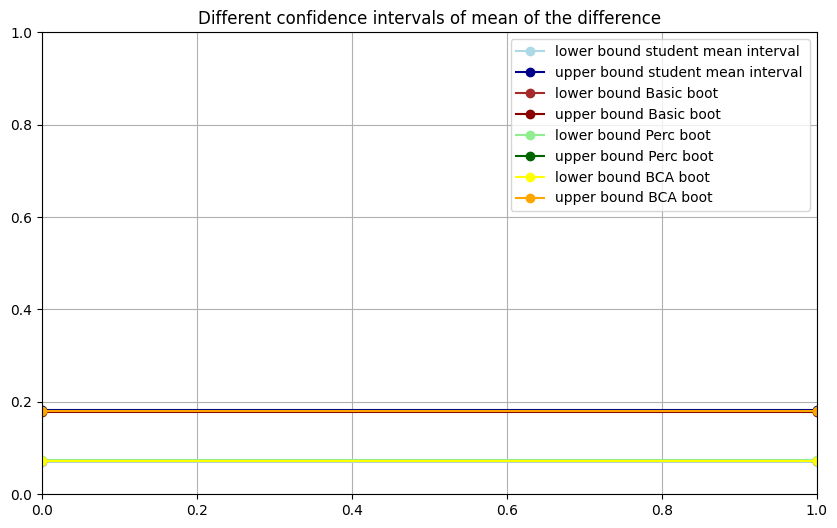

The following bilateral test checks if your hypothesis on the equal performance of two models is reasonable :
The p-value of the bilateral test is : 0.4497552268124321
The power of the bilateral test is : 0.03277104463488678
The bootstrapped p-value of the bilateral test is : 0.4495418950987953
The bootstrapped power of the bilateral test is : 0.03277104463488678
Les données ont été sauvegardées dans le fichier Summary/statistics_comparison_Logistic_vs_DecisionTree_gamma90_summary.json


In [5]:
descriptive_statistics()

In [6]:
import pymc3 as pm

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


Our assumptions are the following :

We know that the errors follow a chi-2 with 1 ddof. (likelihood)
So we make the prior that our real means follow an inversed chi-2.




The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu quadratic, mu linear]
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The versi

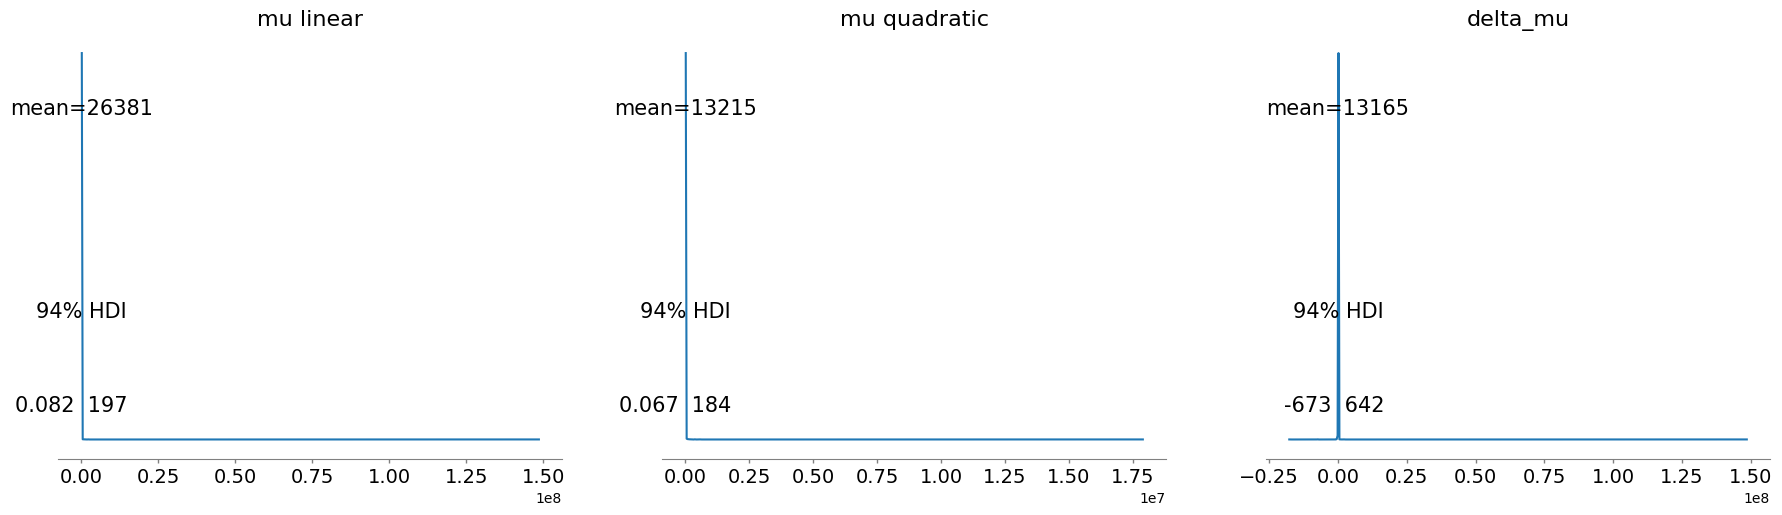

Probabilité que la différence des moyennes soit supérieure à 0 : 0.50


In [17]:
# Modèle bayésien avec PyMC3
with pm.Model() as model:
    # Priors pour les variances, utilisant la distribution Inverse Gamma
    mu1 = pm.InverseGamma('mu linear', alpha=0.5, beta=0.5)
    mu2 = pm.InverseGamma('mu quadratic', alpha=0.5, beta=0.5)
    
    # Likelihood
    y1 = pm.ChiSquared('Likelihood linear', nu=1, observed=errors_A)
    y2 = pm.ChiSquared('Likelihood quadratic', nu=1, observed=errors_B)
    
    # Différence des moyennes
    delta_mu = pm.Deterministic('delta_mu', mu1 - mu2)
    
    # Inference
    trace = pm.sample(2000, return_inferencedata=False)

# Résultats
pm.plot_posterior(trace, var_names=['mu linear', 'mu quadratic', 'delta_mu'])
plt.show()

# Probabilité que la différence des moyennes soit supérieure à 0
delta_mu_samples = trace['delta_mu']
prob_delta_mu_gt_zero = np.mean(delta_mu_samples > 0)
print(f"Probabilité que la différence des moyennes soit supérieure à 0 : {prob_delta_mu_gt_zero:.2f}")

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu quadratic, mu linear]
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The versi

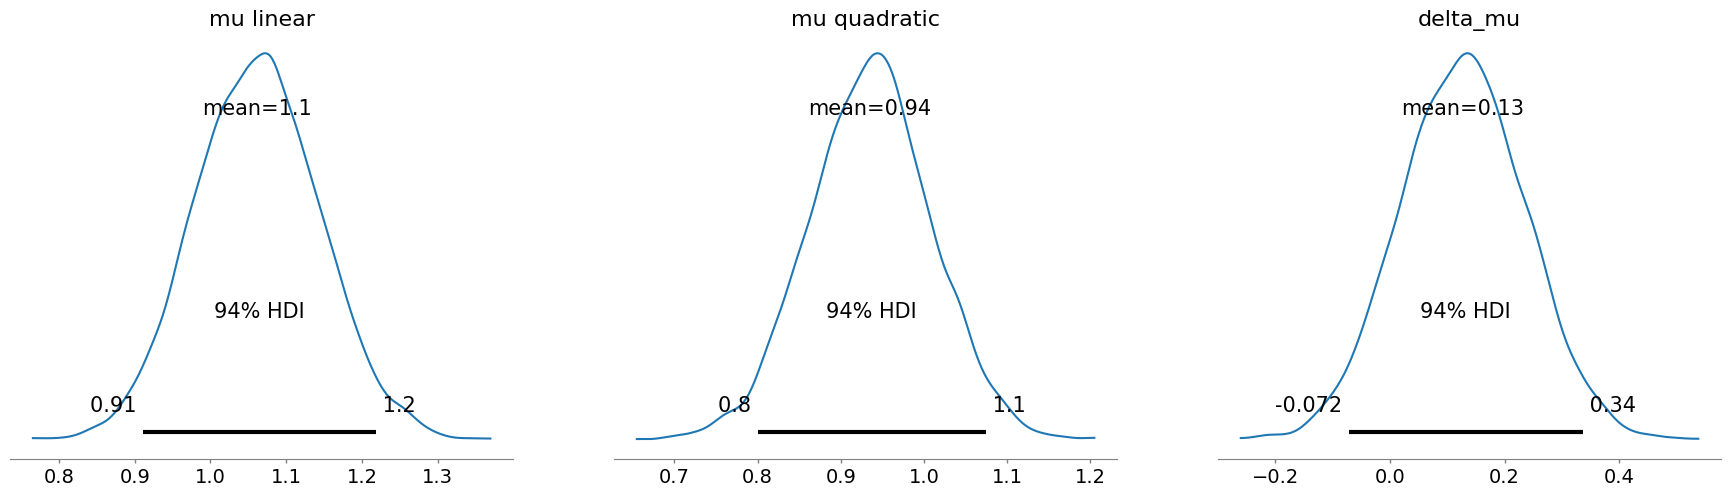

Probabilité que la différence des moyennes soit supérieure à 0 : 0.88


In [18]:
# Modèle bayésien avec PyMC3
with pm.Model() as model:
    # Priors pour les variances, utilisant la distribution Inverse Gamma
    mu1 = pm.InverseGamma('mu linear', alpha=0.5, beta=0.5)
    mu2 = pm.InverseGamma('mu quadratic', alpha=0.5, beta=0.5)
    
    # Likelihood
    y1 = pm.Normal('Likelihood linear', mu=mu1, sigma=sigma_A, observed=errors_A)
    y2 = pm.Normal('Likelihood quadratic', mu=mu2,sigma=sigma_B ,observed=errors_B)
    
    # Différence des moyennes
    delta_mu = pm.Deterministic('delta_mu', mu1 - mu2)
    
    # Inference
    trace = pm.sample(2000, return_inferencedata=False)

# Résultats
pm.plot_posterior(trace, var_names=['mu linear', 'mu quadratic', 'delta_mu'])
plt.show()

# Probabilité que la différence des moyennes soit supérieure à 0
delta_mu_samples = trace['delta_mu']
prob_delta_mu_gt_zero = np.mean(delta_mu_samples > 0)
print(f"Probabilité que la différence des moyennes soit supérieure à 0 : {prob_delta_mu_gt_zero:.2f}")